In [ ]:
import tensorflow as tf
import numpy as np
import scipy.io
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
import scipy.io
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = scipy.io.loadmat('/content/drive/My Drive/PINN/cylinder_nektar_wake.mat')

In [ ]:
data

{'U_star': array([[[ 1.11419216e+00,  1.11755721e+00,  1.11956933e+00, ...,
           1.16105653e+00,  1.16209316e+00,  1.16287446e+00],
         [-4.09649775e-03,  1.09212754e-03,  3.28231641e-03, ...,
          -1.14679740e-02, -1.46226631e-02, -1.78649950e-02]],
 
        [[ 1.11102707e+00,  1.11424311e+00,  1.11623549e+00, ...,
           1.16119046e+00,  1.16250501e+00,  1.16355997e+00],
         [ 3.93130751e-04,  6.09231658e-03,  8.54240777e-03, ...,
          -3.69331211e-03, -6.90960992e-03, -1.02375054e-02]],
 
        [[ 1.10748452e+00,  1.11049848e+00,  1.11244362e+00, ...,
           1.16080365e+00,  1.16241577e+00,  1.16375737e+00],
         [ 4.42777717e-03,  1.06585027e-02,  1.33831464e-02, ...,
           4.14245483e-03,  8.86993440e-04, -2.50609725e-03]],
 
        ...,
 
        [[ 1.04183122e+00,  1.07052197e+00,  1.08570786e+00, ...,
           1.03561691e+00,  1.01482352e+00,  9.95607444e-01],
         [-1.53233747e-01, -1.52906494e-01, -1.50934775e-01, ...,
    

In [ ]:
U_star = data['U_star'].astype('float32') # N x 2 x T
P_star = data['p_star'].astype('float32') # N x T
t_star = data['t'].astype('float32') # T x 1
X_star = data['X_star'].astype('float32') # N x 2

In [ ]:
P_star.shape

(5000, 200)

In [ ]:
X_star[:,0:1]

array([[1.       ],
       [1.0707071],
       [1.1414142],
       ...,
       [7.858586 ],
       [7.929293 ],
       [8.       ]], dtype=float32)

In [ ]:
X_star[:,1:2]

array([[-2.],
       [-2.],
       [-2.],
       ...,
       [ 2.],
       [ 2.],
       [ 2.]], dtype=float32)

In [ ]:
t_star.shape

(200, 1)

In [ ]:
N = X_star.shape[0]
T = t_star.shape[0]
print(N)
print(T)

5000
200


In [ ]:
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T
    
UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

In [ ]:
print(XX)
print(XX.shape)

[[1.        1.        1.        ... 1.        1.        1.       ]
 [1.0707071 1.0707071 1.0707071 ... 1.0707071 1.0707071 1.0707071]
 [1.1414142 1.1414142 1.1414142 ... 1.1414142 1.1414142 1.1414142]
 ...
 [7.858586  7.858586  7.858586  ... 7.858586  7.858586  7.858586 ]
 [7.929293  7.929293  7.929293  ... 7.929293  7.929293  7.929293 ]
 [8.        8.        8.        ... 8.        8.        8.       ]]
(5000, 200)


In [ ]:
print(TT)
print(TT.shape)

[[ 0.   0.1  0.2 ... 19.7 19.8 19.9]
 [ 0.   0.1  0.2 ... 19.7 19.8 19.9]
 [ 0.   0.1  0.2 ... 19.7 19.8 19.9]
 ...
 [ 0.   0.1  0.2 ... 19.7 19.8 19.9]
 [ 0.   0.1  0.2 ... 19.7 19.8 19.9]
 [ 0.   0.1  0.2 ... 19.7 19.8 19.9]]
(5000, 200)


In [ ]:
x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1
    
u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

In [ ]:
x

array([[1.],
       [1.],
       [1.],
       ...,
       [8.],
       [8.],
       [8.]], dtype=float32)

In [ ]:
N_train = 5000


In [ ]:
# Training Data    
idx = np.random.choice(N*T, N_train, replace=False)
x_train = tf.convert_to_tensor(x[idx,:].astype('float32'))
y_train = tf.convert_to_tensor(y[idx,:].astype('float32'))
t_train = tf.convert_to_tensor(t[idx,:].astype('float32'))
u_train = tf.convert_to_tensor(u[idx,:].astype('float32'))
v_train = tf.convert_to_tensor(v[idx,:].astype('float32'))

In [ ]:
tf.concat([x_train,y_train,t_train],1)

<tf.Tensor: shape=(5000, 3), dtype=float32, numpy=
array([[ 6.5151515 ,  1.1836735 ,  4.4       ],
       [ 3.969697  , -0.20408164, 11.8       ],
       [ 7.080808  ,  0.12244898,  6.4       ],
       ...,
       [ 4.181818  , -0.04081633,  7.3       ],
       [ 2.6969697 ,  0.36734694,  1.3       ],
       [ 5.5252523 , -2.        , 18.        ]], dtype=float32)>

In [ ]:
o=np.ones((5000,1)).astype('float32')
o=tf.convert_to_tensor(o)
o

<tf.Tensor: shape=(5000, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)>

Custom Model


In [ ]:
class Custom_model1(Model):
    
    def __init__(self, **kwargs):
        super(Custom_model1, self).__init__(**kwargs)
        self.layer1 = Dense(20, activation='tanh',name='layer1')
        self.layer2 = Dense(20, activation='tanh',name='layer2')
        self.layer3 = Dense(20, activation='tanh',name='layer3')
        self.layer4 = Dense(20, activation='tanh',name='layer4')
        self.layer5 = Dense(20, activation='tanh',name='layer5')
        self.layer6 = Dense(20, activation='tanh',name='layer6')
        self.layer7 = Dense(20, activation='tanh',name='layer7')
        self.layer8 = Dense(20, activation='tanh',name='layer8')
        self.layer9 = Dense(2, activation=None,name='layer9')
        self.layer10 = Dense(2, activation=None,use_bias=False)

    def call(self, x, y, t, o):
        z = self.layer1(tf.concat([x, y, t], 1))
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.layer4(z)
        z = self.layer5(z)
        z = self.layer6(z)
        z = self.layer7(z)
        z = self.layer8(z)
        z = self.layer9(z)
        z1 = self.layer10(o)
        return z,z1


In [ ]:
#class Custom_model2(Model):
    
    #def __init__(self, **kwargs):
        #super(Custom_model2, self).__init__(**kwargs)
        #self.layer1 = Dense(2, activation=None, name='layer1',use_bias=False)
        
    #def call(self, o):
        #return self.layer1(o)

In [ ]:
model = Custom_model1()

In [ ]:
model(x_train, y_train, t_train,o)

(<tf.Tensor: shape=(5000, 2), dtype=float32, numpy=
 array([[ 0.27631244,  0.16898388],
        [-0.1041702 , -0.09406869],
        [ 0.2534911 ,  0.19206755],
        ...,
        [-0.00285088,  0.03544   ],
        [ 0.3095044 ,  0.13134691],
        [-0.10985117, -0.10299194]], dtype=float32)>,
 <tf.Tensor: shape=(5000, 2), dtype=float32, numpy=
 array([[0.056319 , 0.7510258],
        [0.056319 , 0.7510258],
        [0.056319 , 0.7510258],
        ...,
        [0.056319 , 0.7510258],
        [0.056319 , 0.7510258],
        [0.056319 , 0.7510258]], dtype=float32)>)

In [ ]:
model.layer10.trainable_weights

[<tf.Variable 'custom_model1/dense/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[0.056319 , 0.7510258]], dtype=float32)>]

In [ ]:
#outputLayerNN = model1.get_layer(name='layer9')
#outputLayerNN

In [ ]:
model.summary()

Model: "custom_model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               multiple                  80        
_________________________________________________________________
layer2 (Dense)               multiple                  420       
_________________________________________________________________
layer3 (Dense)               multiple                  420       
_________________________________________________________________
layer4 (Dense)               multiple                  420       
_________________________________________________________________
layer5 (Dense)               multiple                  420       
_________________________________________________________________
layer6 (Dense)               multiple                  420       
_________________________________________________________________
layer7 (Dense)               multiple                

In [ ]:
#outputLayerLambda = model2.get_layer(name='layer1')
#outputLayerLambda.trainable_variables

In [ ]:
#outputLayerNN = model1(x_train,y_train,t_train)
#outputLayerLambda = model2(o)

In [ ]:
#z = model1.layer1(tf.concat([x_train, y_train, t_train], 1))
#z = model1.layer2(z)
#z = model1.layer3(z)
#z = model1.layer4(z)
#z = model1.layer5(z)
#z = model1.layer6(z)
#z = model1.layer7(z)
#z = model1.layer8(z)
#outputLayerNN = model1.layer9(z)

#outputLayerLambda=model2.layer1(o)'''

In [ ]:
#concatenated_layer = tf.keras.layers.concatenate([outputLayerNN,outputLayerLambda],axis=1)
#concatenated_layer

In [ ]:
#input_new = tf.concat([x_train,y_train,t_train,o],1)
#concatenated_layer = tf.keras.layers.Lambda(concatenated_layer)
#model_new = Model(inputs=[x_train,y_train,t_train,o], outputs = concatenated_layer)
#model_new = Model(inputs = Input(tensor=input_new), outputs = concatenated_layer)

Custom Loss

In [ ]:
#lambda1=0.0 
#lambda2=0.0
#lambda1

In [ ]:
def loss(model, u_train, v_train, x_train, y_train, t_train, o, training):
  with tf.GradientTape(persistent = True) as t:
    t.watch(x_train)
    t.watch(y_train)
    pred,lambd = model(x_train, y_train, t_train, o, training = training)
    psi=pred[:,0:1]
  u_pred=t.gradient(psi,y_train)
  v_pred=-t.gradient(psi,x_train)
  #f_u, f_v = residual_loss(model,x_train,y_train,t_train,o,lambd)
  f_u, f_v = residual_loss(model,x_train,y_train,t_train,o)
  return tf.reduce_mean(tf.square(u_train - u_pred)) + tf.reduce_mean(tf.square(v_train - v_pred)) + tf.reduce_mean(tf.square(f_u)) + tf.reduce_mean(tf.square(f_v))

In [ ]:
def residual_loss(model,x,y,t,o):
  #lambda1 = lambd[:,0:1]
  #lambda2 = lambd[:,1:2]
  with tf.GradientTape(persistent = True) as t3:
    t3.watch(x)
    t3.watch(y)
    with tf.GradientTape(persistent = True) as t2:
      t2.watch(x)
      t2.watch(y)
      t2.watch(t)
      with tf.GradientTape(persistent = True) as t1:
        t1.watch(x)
        t1.watch(y)
        pred,lambd = model(x,y,t,o)
        psi=pred[:,0:1]
        p=pred[:,1:2]
        lambda1=lambd[:,0:1]
        lambda2=lambd[:,1:2]
      u = t1.gradient(psi,y)
      v = -t1.gradient(psi,x)
      p_x = t1.gradient(p,x)
      p_y = t1.gradient(p,y)
    u_t = t2.gradient(u,t)
    u_x = t2.gradient(u,x)
    u_y = t2.gradient(u,y)
    v_t = t2.gradient(v,t)
    v_x = t2.gradient(v,x)
    v_y = t2.gradient(v,y) 
  u_xx = t3.gradient(u_x,x)
  u_yy = t3.gradient(u_y,y)
  v_xx = t3.gradient(v_x,x)
  v_yy = t3.gradient(v_y,y)
  f_u = u_t + lambda1*(u*u_x + v*u_y) + p_x - lambda2*(u_xx + u_yy) 
  f_v = v_t + lambda1*(u*v_x + v*v_y) + p_y - lambda2*(v_xx + v_yy)
  return f_u, f_v

In [ ]:
loss(model, u_train, v_train, x_train, y_train, t_train, o, training = True)

<tf.Tensor: shape=(), dtype=float32, numpy=0.92958546>

In [ ]:
model.layer10.trainable_variables

[<tf.Variable 'custom_model1/dense/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[0.056319 , 0.7510258]], dtype=float32)>]

In [ ]:
def train(model, u_train, v_train, x_train, y_train, t_train,o):
    with tf.GradientTape() as t:
        current_loss = loss(model, u_train, v_train, x_train, y_train, t_train, o, training = True)
    grads = t.gradient(current_loss, model.trainable_variables)
    return current_loss, grads

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
epoch=[]
loss_plot=[]
model = Custom_model1()
ne=6000
for i in range(ne):
    loss_avg = tf.keras.metrics.Mean()
    c_l,grad=train(model, u_train, v_train, x_train, y_train, t_train, o)
    optimizer.apply_gradients((grad, var) for (grad, var) in zip(grad, model.trainable_variables) if grad is not None)
    loss_avg.update_state(c_l)
  
    if i%100==0:
      epoch.append(i)
      loss_plot.append(loss_avg.result())
      print(loss_avg.result())

tf.Tensor(0.92924327, shape=(), dtype=float32)
tf.Tensor(0.17139624, shape=(), dtype=float32)
tf.Tensor(0.13884725, shape=(), dtype=float32)
tf.Tensor(0.1249384, shape=(), dtype=float32)
tf.Tensor(0.11631265, shape=(), dtype=float32)
tf.Tensor(0.1131788, shape=(), dtype=float32)
tf.Tensor(0.11088176, shape=(), dtype=float32)
tf.Tensor(0.108620174, shape=(), dtype=float32)
tf.Tensor(0.105983876, shape=(), dtype=float32)
tf.Tensor(0.10294626, shape=(), dtype=float32)
tf.Tensor(0.0990378, shape=(), dtype=float32)
tf.Tensor(0.093546085, shape=(), dtype=float32)
tf.Tensor(0.08559264, shape=(), dtype=float32)
tf.Tensor(0.072315946, shape=(), dtype=float32)
tf.Tensor(0.056846604, shape=(), dtype=float32)
tf.Tensor(0.051166117, shape=(), dtype=float32)
tf.Tensor(0.050121114, shape=(), dtype=float32)
tf.Tensor(0.046260633, shape=(), dtype=float32)
tf.Tensor(0.044788957, shape=(), dtype=float32)
tf.Tensor(0.04575721, shape=(), dtype=float32)
tf.Tensor(0.042578124, shape=(), dtype=float32)
tf.Ten

In [ ]:
model.layer10.trainable_variables

[<tf.Variable 'custom_model1_1/dense_1/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[0.9494514 , 0.01444297]], dtype=float32)>]

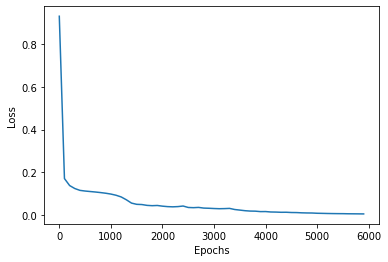

In [ ]:
# Plotting loss v/s epoch
x_plot=epoch
y_plot=loss_plot
plt.plot(x_plot,y_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Test Data
snap = np.array([100])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star = TT[:,snap]
    
u_star = U_star[:,0,snap]
v_star = U_star[:,1,snap]
p_star = P_star[:,snap]

In [ ]:
x_star = tf.convert_to_tensor(x_star)
y_star = tf.convert_to_tensor(y_star)
t_star = tf.convert_to_tensor(t_star)
u_star = tf.convert_to_tensor(u_star)
v_star = tf.convert_to_tensor(v_star)
p_star = tf.convert_to_tensor(p_star)

In [ ]:
with tf.GradientTape(persistent = True) as t:
    t.watch(x_star)
    t.watch(y_star)
    pred,lambd_pred = model(x_star, y_star, t_star, o)
    psi=pred[:,0:1]
    p_pred=pred[:,1:2]
u_pred=t.gradient(psi,y_star)
v_pred=-t.gradient(psi,x_star)

In [ ]:
lambda1_pred=lambd_pred[:,0:1]
lambda2_pred=lambd_pred[:,1:2]
print(lambda1_pred[0])
print(lambda2_pred[0])

tf.Tensor([0.9494514], shape=(1,), dtype=float32)
tf.Tensor([0.01444297], shape=(1,), dtype=float32)


In [ ]:
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
    error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)

    error_lambda_1 = np.abs(lambda1_pred[0] - 1.0)*100
    error_lambda_2 = np.abs(lambda2_pred[0] - 0.01)/0.01 * 100

In [ ]:
    print('Error u: %e' % (error_u))    
    print('Error v: %e' % (error_v))    
    print('Error p: %e' % (error_p))    
    print('Error l1: %.5f%%' % (error_lambda_1))                             
    print('Error l2: %.5f%%' % (error_lambda_2))   

Error u: 4.812890e-02
Error v: 1.776092e-01
Error p: 1.129468e+01
Error l1: 5.05486%
Error l2: 44.42966%


In [ ]:
u_pred = np.array(u_pred)
v_pred = np.array(v_pred)
p_pred = np.array(p_pred)
p_star = np.array(p_star)
x_star = np.array(x_star)
y_star = np.array(y_star)
t_star = np.array(t_star)


In [ ]:
    from scipy.interpolate import griddata
    lb = X_star.min(0)
    ub = X_star.max(0)
    nn = 200
    x = np.linspace(lb[0], ub[0], nn)
    y = np.linspace(lb[1], ub[1], nn)
    X, Y = np.meshgrid(x,y)
    
    UU_star = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
    VV_star = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')
    PP_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')
    P_exact = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')

Text(0.5, 1.0, 'Predicted pressure')

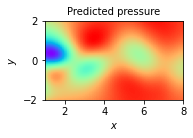

In [ ]:
    from matplotlib import gridspec
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from matplotlib.pyplot import colorbar

    gs2 = gridspec.GridSpec(1, 2)
    gs2.update(top=1, bottom=1-1/2, left=0.1, right=0.9, wspace=0.5)
    ax = plt.subplot(gs2[:, 0])
    h = ax.imshow(PP_star, interpolation='nearest', cmap='rainbow', 
                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
                  origin='lower', aspect='auto')
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)

    #fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_aspect('equal', 'box')
    ax.set_title('Predicted pressure', fontsize = 10)

Text(0.5, 1.0, 'Exact pressure')

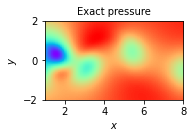

In [ ]:
    ax = plt.subplot(gs2[:, 1])
    h = ax.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
                  origin='lower', aspect='auto')
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)

    #fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_aspect('equal', 'box')
    ax.set_title('Exact pressure', fontsize = 10)

(-2.0, 2.0)

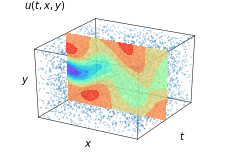

In [ ]:
    from matplotlib import gridspec
    gs1 = gridspec.GridSpec(1, 2)
    gs1.update(top=1-2/4, bottom=0.0, left=0.01, right=0.99, wspace=0)
    ax = plt.subplot(gs1[:, 0],  projection='3d')
    ax.axis('off')

    r1 = [x_star.min(), x_star.max()]
    r2 = [data['t'].min(), data['t'].max()]       
    r3 = [y_star.min(), y_star.max()]
    
    for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
        if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
            ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

    ax.scatter(x_train, t_train, y_train, s = 0.1)
    ax.contourf(X,UU_star,Y, zdir = 'y', offset = t_star.mean(), cmap='rainbow', alpha = 0.8)
              
    ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
    ax.text(x_star.max()+1, data['t'].mean(), y_star.min() - 1, '$t$')
    ax.text(x_star.min()-1, data['t'].min() - 0.5, y_star.mean(), '$y$')
    ax.text(x_star.min()-3, data['t'].mean(), y_star.max() + 1, '$u(t,x,y)$')    
    ax.set_xlim3d(r1)
    ax.set_ylim3d(r2)
    ax.set_zlim3d(r3)
    #axisEqual3D(ax)

(-2.0, 2.0)

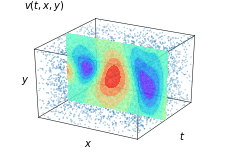

In [ ]:
    ax = plt.subplot(gs1[:, 1],  projection='3d')
    ax.axis('off')
    
    r1 = [x_star.min(), x_star.max()]
    r2 = [data['t'].min(), data['t'].max()]       
    r3 = [y_star.min(), y_star.max()]
    
    for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
        if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
            ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

    ax.scatter(x_train, t_train, y_train, s = 0.1)
    ax.contourf(X,VV_star,Y, zdir = 'y', offset = t_star.mean(), cmap='rainbow', alpha = 0.8)
              
    ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
    ax.text(x_star.max()+1, data['t'].mean(), y_star.min() - 1, '$t$')
    ax.text(x_star.min()-1, data['t'].min() - 0.5, y_star.mean(), '$y$')
    ax.text(x_star.min()-3, data['t'].mean(), y_star.max() + 1, '$v(t,x,y)$')    
    ax.set_xlim3d(r1)
    ax.set_ylim3d(r2)
    ax.set_zlim3d(r3)